<a href="https://colab.research.google.com/github/freshq99/Colab/blob/main/AutoencoderDenoisePro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


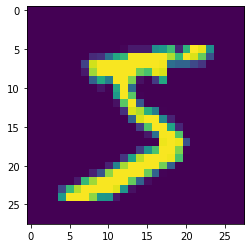

In [6]:
plt.imshow(X_train[0])

In [7]:
X_train, X_test = X_train/255.0, X_test/255

In [8]:
#Mischiamo i dati
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

## Basic AutoEncoder

In [14]:
class MyEncoder(Model):
  def __init__(self):
    super(MyEncoder, self).__init__()
    self.flatten = Flatten(input_shape=[28,28])
    self.d1 = Dense(400,activation="relu")
    self.d2 = Dense(200,activation="relu")
    self.d3 = Dense(100,activation="relu")
    self.d4 = Dense(50,activation="relu")
    self.d5 = Dense(25,activation="relu")

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)
    return self.d5(x)

#Creo il modello
encoder = MyEncoder()

In [16]:
class MyDecoder(Model):
  def __init__(self):
    super(MyDecoder, self).__init__()
    self.d6 = Dense(50,input_shape=[25],activation='relu')
    self.d7 = Dense(100,activation="relu")
    self.d8 = Dense(200,activation="relu")
    self.d9 = Dense(400,activation="relu")
    self.d10 = Dense(28 * 28, activation="sigmoid")
    self.reshape = Reshape([28, 28])

  def call(self, x):
    x = self.d6(x)
    x = self.d7(x)
    x = self.d8(x)
    x = self.d9(x)
    x = self.d10(x)
    return self.reshape(x)

#Creo il modello
encoder = MyDecoder()

In [17]:
MyAutoencoder = (MyEncoder, MyDecoder)

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [19]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [21]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = MyAutoencoder(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, MyAutoencoder.trainable_variables)
  optimizer.apply_gradients(zip(gradients, MyAutoencoder.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [22]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = MyAutoencoder(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [24]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, 
               labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )


TypeError: ignored